In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle 
import quandl
import codecs
from datetime import datetime
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation

C:\Users\youngtec\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 先定義幾個子函數

### 下載來自Quandl的資料集

In [2]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries''' 
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-') 
    
    #Enter quandl API Key
    quandl.ApiConfig.api_key = "zQm4uFHeJru86SyaLs6v"
    
    print('Downloading {} from Quandl'.format(quandl_id)) 
    df = quandl.get(quandl_id, returns="pandas") 
    df.to_pickle(cache_path) 
    print('Cached {} at {}'.format(quandl_id, cache_path)) 
    return df

### 從不同的DataFrame萃取出特定的欄位合併成新的DataFrame

In [3]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe''' 
    series_dict = {} 
    for index in range(len(dataframes)): 
        series_dict[labels[index]] = dataframes[index][col] 
    return pd.DataFrame(series_dict)

### 從Poloniex抓取更多其他虛擬貨幣的價格

#### 讀取JSON檔

In [4]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.''' 
    print('Downloading {}'.format(json_url)) 
    #df = pd.read_json(codecs.open(json_url,'r','utf-8'))
    df = pd.read_json(json_url) 
    df.to_pickle(cache_path) 
    print('Cached {} at {}'.format(json_url, cache_path)) 
    return df

#### Poloniex抓取資料

In [5]:
def get_crypto_data(poloniex_pair): 
    base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}' 
    start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') # get data from the start of 2016
    end_date = datetime.now() # up until today
    pediod = 86400 # pull daily data (86,400 seconds per day) 
    '''Retrieve cryptocurrency data from poloniex''' 
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod) 
    data_df = get_json_data(json_url, poloniex_pair) 
    data_df = data_df.set_index('date')
    return data_df 

In [6]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

In [8]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

In [9]:
def extract_window_data(df, window=14, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [10]:
def prepare_data(df, window=14, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.average[window:].values
    y_test = test_data.average[window:].values
    if zero_base:
        y_train = y_train / train_data.average[:-window].values - 1
        y_test = y_test / test_data.average[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [11]:
def build_lstm_model(input_data, output_size, neurons=20,
                     activ_func='linear', dropout=0.25,
                     loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

# 開始抓取資料

In [12]:
# Pull pricing data form 4 BTC exchanges 
exchanges = ['COINBASE','BITSTAMP','ITBIT','KRAKEN'] 
exchange_data = {} 
for exchange in exchanges: 
    exchange_code = 'BCHARTS/{}USD'.format(exchange) 
    btc_exchange_df = get_quandl_data(exchange_code) 
    exchange_data[exchange] = btc_exchange_df 

Cached BCHARTS/COINBASEUSD at BCHARTS-COINBASEUSD.pkl
Cached BCHARTS/BITSTAMPUSD at BCHARTS-BITSTAMPUSD.pkl
Cached BCHARTS/ITBITUSD at BCHARTS-ITBITUSD.pkl
Cached BCHARTS/KRAKENUSD at BCHARTS-KRAKENUSD.pkl


In [13]:
# merge the  BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')
# extract data after 2016
btc_usd_datasets = btc_usd_datasets.loc[btc_usd_datasets.index >= '2016-01-01']
# Remove "0" values 
btc_usd_datasets.replace(0, np.nan, inplace=True)
# replace nan with row mean
fill_value = pd.DataFrame({col: btc_usd_datasets.mean(axis=1) for col in btc_usd_datasets.columns})
btc_usd_datasets = btc_usd_datasets.fillna(value=fill_value)
#
btc_usd_datasets['average'] = btc_usd_datasets.mean(axis=1)

In [14]:
#btc_usd_datasets

In [15]:
# 從Poloniex下載交易資料 我們將下載4個虛擬貨幣： Ethereum，Litecoin，Ripple，Monero的交易資料
altcoins = ['ETH','LTC','XRP','XMR']
altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'USDT_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451577600.0&end=1559811181.604878&period=86400 at USDT_ETH
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451577600.0&end=1559811183.525224&period=86400 at USDT_LTC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451577600.0&end=1559811184.132671&period=86400 at USDT_XRP
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XMR&start=1451577600.0&end=1559811184.729075&period=86400 at USDT_XMR


In [16]:
# merge price dataseries' into a single dataframe
altcoin_usd_datasets = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'weightedAverage')
# Remove "0" values 
altcoin_usd_datasets.replace(0, np.nan, inplace=True)

In [17]:
#altcoin_usd_datasets

In [18]:
hist = pd.merge(btc_usd_datasets,altcoin_usd_datasets, left_index=True, right_index=True)

In [19]:
train, test = train_test_split(hist, test_size=0.1)

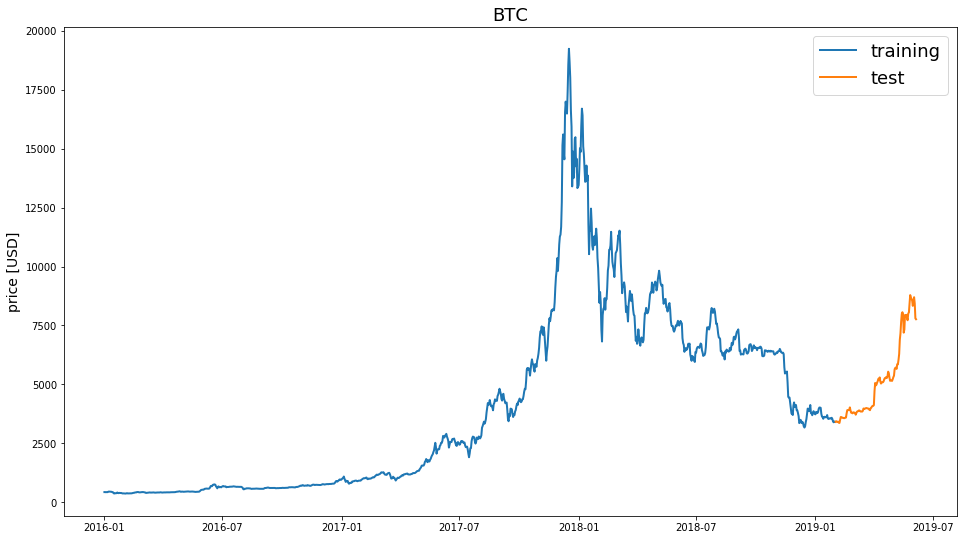

In [20]:
line_plot(train.average, test.average, 'training', 'test', 'BTC')

In [21]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [ ]:
model = build_lstm_model(X_train, output_size=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=4)

Epoch 1/200
1113/1113 [==============================] - 10s 9ms/step - loss: nan
Epoch 2/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 3/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 4/200
1113/1113 [==============================] - 812s 730ms/step - loss: nan
Epoch 5/200
1113/1113 [==============================] - 8s 8ms/step - loss: nan
Epoch 6/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 7/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 8/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 9/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 10/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 11/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 12/200
1113/1113 [==============================] - 8s 7ms/step - loss: nan
Epoch 13/200
1113/11

In [ ]:
target_col='average'
window=14
targets_pre = test[target_col][window-1:]
targets = test[target_col][window:]

In [ ]:
preds = model.predict(X_test).squeeze()
# convert change predictions back to actual price
preds = test.average.values[:-window] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
n = 30
line_plot(targets[-n:][:-1], preds[-n:].shift(-1), 'actual', 'prediction')

In [ ]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k')
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)
# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k')
ax2.set_title('r = {:.2f}'.format(corr));